In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import assemble, Aer, transpile, execute
from qiskit import BasicAer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.visualization import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.kernels import QuantumKernel

import sklearn
from sklearn import metrics

import pandas as pd

In [4]:
def getDataWithStatsFeatures(xDropped):
    
    data = pd.DataFrame()
    data['CONS_NO'] = xDropped['CONS_NO']
    data['FLAG'] = xDropped['FLAG']
    data['Mean'] = xDropped.iloc[:,2:].mean(axis=1, skipna=True, numeric_only=True)
    data['Median'] = xDropped.iloc[:,2:].median(axis=1, skipna=True, numeric_only=True )
    data['Standard deviation'] = xDropped.iloc[:,2:].std(axis=1, skipna=True, numeric_only=True)
    data['Variance'] = xDropped.iloc[:,2:].var(axis=1, skipna=True, numeric_only=True )
    data['Kurtosis'] = xDropped.iloc[:,2:].kurtosis(axis=1, skipna=True, numeric_only=True)
    data['Skew'] = xDropped.iloc[:,2:].skew(axis=1, skipna=True, numeric_only=True )
    data['5%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.05)
    data['10%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.1)
    data['20%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.2)
    data['25%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.25)
    data['30%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.3)
    data['40%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.4)
    data['60%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.6)
    data['75%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.75)
    data['80%'] = xDropped.iloc[:,2:].quantile(axis=1, numeric_only=True, q = 0.8)
    
    data['Error in mean'] = data['Standard deviation']/len(xDropped.columns)
    
    return data

In [5]:
def getFeaturesLabels(data):
    
    features = np.zeros((len(data), 6))
    features[:,0] = np.array(data['Median'])
    features[:,1] = np.array(data['Standard deviation'])
    features[:,2] = np.array(data['Variance'])
    features[:,3] = np.array(data['Skew'])
    features[:,4] = np.array(data['Kurtosis'])
    features[:,5] = np.array(data['75%'])

    labels = np.array(data['FLAG'])
    
    return features, labels

In [6]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [7]:
def getTrainTestData(features, labels, splitPercentage1 = 0.9, splitPercentage2 = 0.7, inclLabel1inXtrain = True):
    
    if inclAllLabel1inXtrain == True:
            
            np.random.seed(555555)
            Xtrain = features[labels==1]
            ind1 = np.random.choice(np.arange(0, len(features[labels==1])), int(len(features[labels==1])*splitPercentage2), replace=False)
            ind = np.random.choice(np.arange(len(features[labels==1]), len(features)), int(len(features)*splitPercentage1-len(labels[labels==1])*splitPercentage2), replace=False)
            Xtrain = Xtrain[ind1]
            xt = features[ind]
            Xtrain = np.concatenate((Xtrain, xt))
            Ytrain = np.concatenate((labels[labels==1][ind1], labels[ind]))
            temp = np.arange(Xtrain.shape[0])
            np.random.shuffle(temp)
            Xtrain, Ytrain = Xtrain[temp], Ytrain[temp]
            Xtest1 = np.delete(features, ind, axis=0)[len(labels[labels==1]):]
            Ytest1 = np.zeros((len(Xtest1)), int)
            Xtest2 = np.delete(features[:len(labels[labels==1])], ind1, axis=0)
            Ytest2 = np.ones((len(Xtest2)), int)
            Xtest = np.concatenate((Xtest1, Xtest2))
            Ytest = np.concatenate((Ytest1, Ytest2))
   
    else:

        Xtrain, Xtest, Ytrain, Ytest = sklearn.model_selection.train_test_split(features, labels,
                                                                   train_size = splitPercentage, random_state=45)
    
    return Xtrain, Ytrain, Xtest, Ytest



In [8]:
def getOptimizedKernel(quantumKernel, Xtrain, Ytrain):
    
    cb_qkt = QKTCallback()
    spsaOpt = SPSA(maxiter=15, callback=cb_qkt.callback, learning_rate=0.1, perturbation=0.2)

    qkt = QuantumKernelTrainer(quantum_kernel=quantumKernel, loss="svc_loss", optimizer=spsaOpt,
                           initial_point=[0.1])
    print('parameter training started...')
    qkaResults = qkt.fit(Xtrain, Ytrain)
    print('parameter training done...')
    optimizedKernel = qkaResults.quantum_kernel
    plot_data = cb_qkt.get_callback_data()

    return optimizedKernel, qkaResults, plot_data

In [9]:
def getQuantumKernel(Xtrain, Ytrain, featureDim, custom):

    backend = QuantumInstance(BasicAer.get_backend("statevector_simulator"))

    qc = QuantumCircuit(3)
    params = ParameterVector("θ", 1)
    param_data = ParameterVector("x", 6)
    qc.h([0,1,2])
    qc.ry(params[0], [0,1,2])
    qc.cz(0,1)
    qc.rx(-2*param_data[1], 1)
    qc.rz(-2*param_data[3], 1)
    qc.cz(0,1)
    qc.barrier()
    qc.cz(1,2)
    qc.rx(-2*param_data[2], 2)
    qc.rz(-2*param_data[4], 2)
    qc.cz(1,2)
    qc.barrier()
    qc.cz(2,0)
    qc.rx(-2*param_data[0], 0)
    qc.rz(-2*param_data[5], 0)
    qc.cz(2,0)
    qc.barrier()
    qc.rz(params[0], [0,1,2])

    fM = ZZFeatureMap(feature_dimension = featureDim, reps = 1, data_map_func=None)
    
    
    if custom == True:
        featureMap = qc
        quantumKernel = QuantumKernel(feature_map = featureMap, user_parameters=params, quantum_instance = backend)
        optimizedKernel, qkaResults, plot_data = getOptimizedKernel(quantumKernel, Xtrain, Ytrain)
        
        return optimizedKernel, plot_data, qkaResults
    
    else:
        
        featureMap = fM
        quantumKernel = QuantumKernel(feature_map = featureMap, quantum_instance = backend)
    
        return quantumKernel

## QSVM using ZZ feature map 

(on whole dataset-balanced with Classical KNN)

In [46]:
x = pd.read_csv("electricity_KNNImputer.csv")

In [47]:
x

,Unnamed: 0,FLAG,CONS_NO,2014/01/01,2014/01/10,2014/01/11,2014/01/12,2014/01/13,2014/01/14,2014/01/15,...,2016/09/28,2016/09/29,2016/09/03,2016/09/30,2016/09/04,2016/09/05,2016/09/06,2016/09/07,2016/09/08,2016/09/09
0,0,1,EDFC78B07BA2908B3395C4EB2304665E,0.000900,0.000900,0.000900,0.001300,0.000000,0.001300,0.001000,...,0.007200,0.0028,0.0063,0.0029,0.0054,0.0036,0.0040,0.0045,0.0041,0.0041
1,1,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.000000,0.000100,0.000100,0.000100,0.000000,0.000200,0.000000,...,0.001700,0.0007,0.0005,0.0007,0.0005,0.0003,0.0001,0.0003,0.0004,0.0004
2,2,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.000300,0.000200,0.000300,0.000200,0.000100,0.001000,0.000300,...,0.001000,0.0007,0.0009,0.0008,0.0014,0.0011,0.0008,0.0008,0.0008,0.0007
3,3,1,516954F5FF177CE314656D727FCC66A5,0.003300,0.002100,0.001800,0.002300,0.000100,0.002300,0.002100,...,0.020700,0.0139,0.0464,0.0131,0.0509,0.0266,0.0217,0.0212,0.0183,0.0193
4,4,1,E34D1B467A365835A4A8AAD9395D49AA,0.002314,0.001918,0.001894,0.002460,0.000094,0.002516,0.002028,...,0.002400,0.0014,0.0023,0.0011,0.0030,0.0014,0.0011,0.0012,0.0009,0.0014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29682,29682,0,5FCE503B6B616D5023B3C46173383107,0.000336,0.000246,0.000244,0.000326,0.000002,0.000372,0.000298,...,0.000200,0.0002,0.0000,0.0001,0.0000,0.0003,0.0002,0.0002,0.0003,0.0001
29683,29683,0,F1472871E1AFF49D4289564B6377D76C,0.001230,0.000840,0.000854,0.001114,0.000024,0.001136,0.000922,...,0.001700,0.0009,0.0014,0.0009,0.0016,0.0009,0.0010,0.0009,0.0008,0.0010
29684,29684,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0.000800,0.001100,0.000900,0.000000,0.000000,0.000000,0.000000,...,0.001900,0.0013,0.0018,0.0008,0.0015,0.0011,0.0008,0.0008,0.0010,0.0009
29685,29685,0,A9A0FE83467A680FBFB0DBFC910DF227,0.000200,0.000200,0.000400,0.000300,0.000000,0.000300,0.000200,...,0.000742,0.0002,0.0012,0.0005,0.0017,0.0010,0.0008,0.0016,0.0005,0.0003


In [48]:
data = getDataWithStatsFeatures(x)
features, labels = getFeaturesLabels(data)

In [49]:
#splitPercentage1: percentage of training dataset
#splitPercentage2: percentage of label 1 in training dataset
Xtrain, Ytrain, Xtest, Ytest = getTrainTestData(features, labels, splitPercentage1=0.1, splitPercentage2=0.5, inclLabel1inXtrain=True)


In [52]:
qk = getQuantumKernel(Xtrain, Ytrain, featureDim = len(features[0]), custom=False)

In [53]:
qsvc = QSVC(quantum_kernel=qk)
qsvc.fit(Xtrain, Ytrain)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7fd370bd3970>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [55]:
labelsTest = qsvc.predict(Xtest)

In [56]:
print(metrics.classification_report(y_true=Ytest, y_pred=labelsTest))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     25595
           1       0.08      0.31      0.12      1124

    accuracy                           0.81     26719
   macro avg       0.52      0.57      0.51     26719
weighted avg       0.93      0.81      0.86     26719



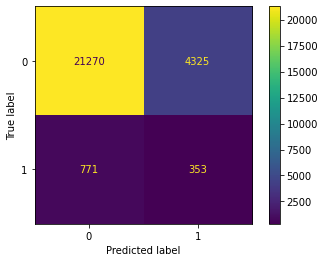

In [57]:
confusionMatrix = metrics.confusion_matrix(y_true=Ytest, y_pred=labelsTest)
disp = metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.show()

## QSVM with Customized QKT
(on 389 datapoints - Completely Balanced Data Set)

In [11]:
x2 = pd.read_csv('dataFeatures.csv')

In [63]:
x2

,CONS_NO,FLAG,Mean,Median,Standard deviation,Variance,Kurtosis,Skew,5%,10%,20%,25%,30%,40%,60%,75%,80%,Error in mean
0,26DA200D4A887F6AA5B94F5682001428,1,3.818836,3.710,1.127881,1.272115,0.477332,0.649697,2.2700,2.490,2.870,2.99,3.130,3.400,4.010,4.4800,4.680,0.001089
1,CD8A4B3D5656402D086D865363A34C4B,1,3.321740,3.360,1.268735,1.609688,1.164593,0.613340,1.5700,1.788,2.110,2.25,2.390,2.792,3.770,4.2400,4.410,0.001225
2,CF9D07950731DB8A0B8A7EECF36A23AE,1,1.435686,1.310,0.834369,0.696172,10.293564,2.524796,0.6800,0.730,0.820,0.86,0.900,1.106,1.360,1.6300,1.712,0.000805
3,3E81EC817E9218F25816849A3EDF5FF2,1,3.262820,2.030,2.372969,5.630983,-0.561642,0.723519,0.7855,0.960,1.160,1.25,1.370,1.604,3.964,5.2425,5.608,0.002291
4,A403518D4F4BB4C5ADAF2AB493F428EE,1,2.479466,2.030,1.800767,3.242762,4.318327,1.769351,0.7600,0.878,1.030,1.10,1.170,1.480,2.460,3.2700,3.670,0.001738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,DCE646E046BC44652E7A55CEACD2AACC,0,2.022405,0.060,3.148678,9.914176,1.099013,1.458710,0.0200,0.020,0.030,0.04,0.050,0.050,0.130,3.9400,4.730,0.003039
385,547DC45410AAC93310C4DF5BD457EBF5,0,1.272176,1.220,0.142124,0.020199,1.524804,1.236278,1.1700,1.170,1.190,1.19,1.200,1.210,1.230,1.2600,1.352,0.000137
386,AD5979AF8F51F35C53AB02E476529AAF,0,2.995220,3.090,0.693215,0.480547,0.550070,-0.144030,1.7210,2.044,2.440,2.57,2.680,2.880,3.260,3.4500,3.520,0.000669
387,CA7BB18FCA3977462061AE789E15E1FA,0,3.661398,3.585,1.417315,2.008782,-0.055432,0.327177,1.3545,1.899,2.428,2.65,2.867,3.220,3.954,4.6200,4.850,0.001368


In [12]:
data1 = getDataWithStatsFeatures(x2)
features1, labels1 = getFeaturesLabels(data1)

In [13]:
#splitPercentage1: percentage of training dataset
# splitPercentage2: percentage of label 1 in training dataset
Xtrain1, Ytrain1, Xtest1, Ytest1 = getTrainTestData(features1, labels1, splitPercentage1=0.5, splitPercentage2=0.7, inclLabel1inXtrain=True)


In [58]:
qkt, plot_data, qkaResults = getQuantumKernel(Xtrain1, Ytrain1, featureDim = len(features1[0]), custom=True)
qsvckt = QSVC(quantum_kernel=qkt)
qsvckt.fit(Xtrain, Ytrain)

parameter training started...
parameter training done...


QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7fd39d168fa0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [59]:
labelsTest1 = qsvckt.predict(Xtest1)

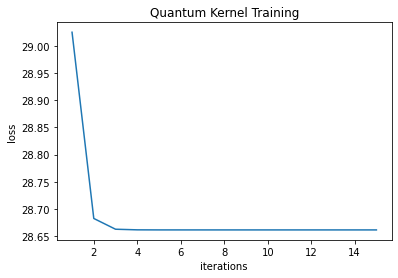

In [60]:
plt.figure()
plt.plot(np.arange(len(plot_data[0]))+1, plot_data[2])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Quantum Kernel Training')
plt.show()

In [61]:
print(metrics.classification_report(y_true=Ytest1, y_pred=labelsTest1, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.72      0.83       188
           1       0.04      0.29      0.07         7

    accuracy                           0.71       195
   macro avg       0.50      0.50      0.45       195
weighted avg       0.93      0.71      0.80       195



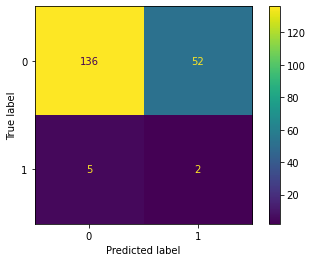

In [62]:
confusionMatrix = metrics.confusion_matrix(y_true=Ytest1, y_pred=labelsTest1)
disp = metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.show()